# DoWhy: Different estimation methods for causal inference
This is quick introduction to DoWhy causal inference library.
We will load in a sample dataset and use different methods for estimating causal effect from a (pre-specified)treatment variable to a (pre-specified) outcome variable.

First, let us add required path for python to find DoWhy code and load required packages.

In [1]:
import os, sys
sys.path.append(os.path.abspath("../../"))

In [2]:
import numpy as np
import pandas as pd
import logging

import dowhy
from dowhy.do_why import CausalModel
import dowhy.datasets 

Let us first load a dataset. For simplicity, we simulate a dataset with linear relationships between common causes and treatment, and common causes and outcome. 

Beta is the true causal effect. 

In [3]:
data = dowhy.datasets.linear_dataset(beta=10,
        num_common_causes=5, 
        num_instruments = 2,
        num_samples=10000,
        treatment_is_binary=True)
df = data["df"]


Note that we are using a pandas dataframe to load the data.

## Identifying the causal estimand

We now input a causal graph in the DOT graph format.

In [4]:
# With graph
model=CausalModel(
        data = df,
        treatment=data["treatment_name"],
        outcome=data["outcome_name"],
        graph=data["gml_graph"],
        instruments=data["instrument_names"],
        logging_level = logging.INFO
        )

Model to find the causal effect of treatment v on outcome y


In [5]:
model.view_model()

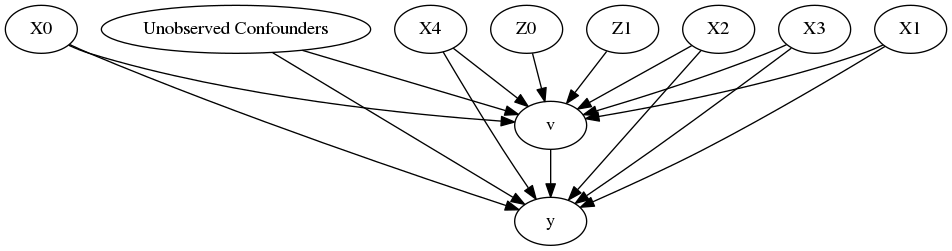

In [6]:
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

We get a causal graph. Now identification and estimation is done. 

In [7]:
identified_estimand = model.identify_effect()
print(identified_estimand)

INFO:dowhy.causal_identifier:Common causes of treatment and outcome:{'X4', 'X2', 'X3', 'Z1', 'X1', 'X0', 'Z0', 'Unobserved Confounders'}


{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'yes'}
{'observed': 'no'}
There are unobserved common causes. Causal effect cannot be identified.
WARN: Do you want to continue by ignoring these unobserved confounders? [y/n] y


INFO:dowhy.causal_identifier:Instrumental variables for treatment and outcome:['Z0', 'Z1']


Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)



## Method 1: Regression

Use linear regression.

In [8]:
causal_estimate_reg = model.estimate_effect(identified_estimand,
        method_name="backdoor.linear_regression",
        test_significance=True)
print(causal_estimate_reg)
print("Causal Estimate is " + str(causal_estimate_reg.value))

LinearRegressionEstimator


INFO:dowhy.causal_estimator:INFO: Using Linear Regression Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X2+X3+Z1+X1+X0+Z0


*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)

## Realized estimand
b: y~v+X4+X2+X3+Z1+X1+X0+Z0
## Estimate
Value: 9.999999999998922

## Statistical Significance
p-value: 0.0

Causal Estimate is 10.0


## Method 2: Stratification

We will be using propensity scores to stratify units in the data.

In [9]:
causal_estimate_strat = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_stratification")
print(causal_estimate_strat)
print("Causal Estimate is " + str(causal_estimate_strat.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Stratification Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X2+X3+Z1+X1+X0+Z0


PropensityScoreStratificationEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)

## Realized estimand
b: y~v+X4+X2+X3+Z1+X1+X0+Z0
## Estimate
Value: 10.04383313279146

Causal Estimate is 10.0438331328


## Method 3: Matching

We will be using propensity scores to match units in the data.

In [10]:
causal_estimate_match = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_matching")
print(causal_estimate_match)
print("Causal Estimate is " + str(causal_estimate_match.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Matching Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X2+X3+Z1+X1+X0+Z0


PropensityScoreMatchingEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)

## Realized estimand
b: y~v+X4+X2+X3+Z1+X1+X0+Z0
## Estimate
Value: 10.505417270444303

Causal Estimate is 10.505417270444303


## Method 4: Weighting

We will be using (inverse) propensity scores to assign weights to units in the data.

In [11]:
causal_estimate_ipw = model.estimate_effect(identified_estimand,
        method_name="backdoor.propensity_score_weighting")
print(causal_estimate_ipw)
print("Causal Estimate is " + str(causal_estimate_ipw.value))

INFO:dowhy.causal_estimator:INFO: Using Propensity Score Weighting Estimator
INFO:dowhy.causal_estimator:b: y~v+X4+X2+X3+Z1+X1+X0+Z0


PropensityScoreWeightingEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)

## Realized estimand
b: y~v+X4+X2+X3+Z1+X1+X0+Z0
## Estimate
Value: 13.895726520600043

Causal Estimate is 13.8957265206


## Method 5: Instrumental Variable

We will be using Wald estimator for the provided instrumental variable.

In [12]:
causal_estimate_iv = model.estimate_effect(identified_estimand,
        method_name="iv.instrumental_variable", method_params={'iv_instrument_name':'Z1'})
print(causal_estimate_iv)
print("Causal Estimate is " + str(causal_estimate_iv.value))

INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                             -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment v isaffected in the same way by common causes of v and y
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome y isaffected in the same way by common causes of v and y



InstrumentalVariableEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                             -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z

## Method 6: Regression Discontinuity

We will be internally converting this to an equivalent instrumental variables problem.

In [13]:
causal_estimate_regdist = model.estimate_effect(identified_estimand,
        method_name="iv.regression_discontinuity", 
        method_params={'rd_variable_name':'Z1',
                       'rd_threshold_value':0.5,
                       'rd_bandwidth': 0.1})
print(causal_estimate_regdist)
print("Causal Estimate is " + str(causal_estimate_regdist.value))

INFO:dowhy.causal_estimator:Using Regression Discontinuity Estimator
INFO:dowhy.causal_estimator:
INFO:dowhy.causal_estimator:INFO: Using Instrumental Variable Estimator
INFO:dowhy.causal_estimator:Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                             -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
Estimand assumption 3, treatment_effect_homogeneity: Each unit's treatment local_treatment isaffected in the same way by common causes of local_treatment and local_outcome
Estimand assumption 4, outcome_effect_homogeneity: Each unit's outcome local_outcome isaffected in the same way by common causes of local_treatment and local_outcome



RegressionDiscontinuityEstimator
*** Causal Estimate ***

## Target estimand
Estimand type: ate
### Estimand : 1
Estimand name: iv
Estimand expression:
Expectation(Derivative(y, Z0)/Derivative(v, Z0))
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then ¬(Z0,Z1→y)
### Estimand : 2
Estimand name: backdoor
Estimand expression:
d                                      
──(Expectation(y|X4,X2,X3,Z1,X1,X0,Z0))
dv                                     
Estimand assumption 1, Unconfoundedness: If U→v and U→y then P(y|v,X4,X2,X3,Z1,X1,X0,Z0,U) = P(y|v,X4,X2,X3,Z1,X1,X0,Z0)

## Realized estimand
Realized estimand: Wald Estimator
Realized estimand type: ate
Estimand expression:
                                                             -1
Expectation(Derivative(y, Z0))⋅Expectation(Derivative(v, Z0))  
Estimand assumption 1, As-if-random: If U→→y then ¬(U →→Z0,Z1)
Estimand assumption 2, Exclusion: If we remove {Z0,Z1}→v, then 